In [2]:
import torchtext
from torchtext.data import functional as textF
from torch import nn, Tensor
from typing import Tuple
import os
import math
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torch.optim as optim
import torch.utils.data as data
import math
import copy

import time
from tqdm import trange, tqdm
import torch.nn.functional as F


import os
from tempfile import TemporaryDirectory

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Currently available device is: ", device)

print("Downloading the Wikitext dataset for pretraining")
url_wiki = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip'
torchtext.utils.download_from_url(url_wiki)
torchtext.utils.extract_archive('/content/.data/wikitext-103-v1.zip', './')

Currently available device is:  cuda


['./wikitext-103/wiki.test.tokens',
 './wikitext-103/wiki.valid.tokens',
 './wikitext-103/wiki.train.tokens']

In [3]:
sp_model = textF.generate_sp_model('./wikitext-103/wiki.train.tokens', vocab_size = 50000, model_type='bpe', model_prefix = 'spm')
sp_model = textF.load_sp_model("/content/spm.model")

In [4]:
class Corpus(object):
    def __init__(self, path, tokenizer_model):
        self.tokenizer = textF.sentencepiece_tokenizer(tokenizer_model)
        self.numericalizer = textF.sentencepiece_numericalizer(tokenizer_model)
        self.train = self.numericalize(os.path.join(path, 'wiki.train.tokens'))
        self.valid = self.numericalize(os.path.join(path, 'wiki.valid.tokens'))

    def flatten_extend(self, matrix):
        flat_list = []
        for row in matrix:
            flat_list.extend(row)
        return flat_list

    def numericalize(self, path):
        assert os.path.exists(path)
        tok_lines = []
        max_tok = 1000000
        with open(path, 'r', encoding="utf8") as f:
            num_tok = 0
            for i, line in tqdm(list(enumerate(f.readlines()))):
                toks = list(self.numericalizer([line]))
                toks = toks[0]
                tok_lines.append(toks)
                num_tok += len(toks)
                if num_tok > max_tok:
                    break
        return torch.tensor(self.flatten_extend(tok_lines))

def random_batch_sampler(tokens, device, batch_size, seq_len):
    n_tokens = tokens.shape[0]
    while True:
        start_indices = torch.randint(0, n_tokens - seq_len + 1, (batch_size,))
        sequences = torch.stack([tokens[start:start + seq_len] for start in start_indices])
        yield sequences.to(device)


def sequential_batch_sampler(tokens, device, batch_size, seq_len):
    n_tokens = tokens.shape[0]
    total_len = batch_size * seq_len

    for i in range(0, n_tokens - total_len + 1, total_len):
        batch = tokens[i:i + total_len].view(batch_size, seq_len)
        yield batch.to(device)

In [5]:
corpus = Corpus("/content/wikitext-103", sp_model)

100%|██████████| 3760/3760 [00:01<00:00, 3305.05it/s]


In [6]:
batch_size = 32
seq_len = 65

train_sampler = random_batch_sampler(corpus.train, device, batch_size, seq_len)
val_sampler = sequential_batch_sampler(corpus.valid, device, batch_size, seq_len)

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs

        self.W_q = nn.Linear(d_model, d_model).to(device) # Query transformation
        self.W_k = nn.Linear(d_model, d_model).to(device) # Key transformation
        self.W_v = nn.Linear(d_model, d_model).to(device) # Value transformation

        self.W_o = nn.Linear(d_model, d_model).to(device) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff).to(device)
        self.fc2 = nn.Linear(d_ff, d_model).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000, dropout=0.1):
        super().__init__()
        self.encoding = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, S, D = x.shape
        positions = torch.arange(S).expand((N, -1)).to(x.device)
        encoded_positions = self.encoding(positions)
        output = x + encoded_positions
        output = self.dropout(output)
        return output

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads)

        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(normalized_shape=d_model)
        self.norm2 = nn.LayerNorm(normalized_shape=d_model)

        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, x, mask):

        attn_output = self.self_attn(x, x, x, mask)

        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, device='cuda'):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, d_model).to(device)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

        self.device = device
        self.to(device)

    def generate_mask(self, src):
        shape = src.shape[-1]
        a = torch.ones(shape, shape)
        mask = torch.tril(a).to(self.device)
        return mask

    def forward(self, src):
        src_mask = self.generate_mask(src)
        src_embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        enc_output = src_embedded
        for layer in self.layers:
            enc_output = layer(enc_output, src_mask)

        return self.fc(enc_output)

In [8]:
#HYPERPARAMETERS FOR PRETRAINING

src_vocab_size = 50000
tgt_vocab_size = 50000
d_model = 300
num_heads = 2
num_layers = 3
d_ff = 300
max_seq_length = 65
dropout = 0.1

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def compute_loss(data, logits):
    labels = data[:,1:]
    logits = logits[:,:-1]
    labels = labels.reshape(-1)
    logits = logits.reshape(-1, logits.size(-1))
    loss = F.cross_entropy(logits, labels)
    return loss

def train(model: nn.Module) -> float:
    model.train()  # turn on train mode
    iter_start_time = time.time()
    total_loss = 0.
    cnt = 0
    iters_loss = 0.

    for step in (pbar := trange(len(corpus.train) // batch_size)):
        data = next(train_sampler)
        output = model(data.to(device))

        loss = compute_loss(data, output)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        iters_loss += loss.item()
        if cnt % 2000 == 0 and cnt > 0:
            train_loss = iters_loss / 2000
            train_ppl = math.exp(train_loss)
            elapsed = time.time() - iter_start_time
            print('\n' + '-' * 100)
            print(f'| iteration {cnt:5d} | time elapsed : {elapsed:5.2f}s | '
                f'train loss {train_loss:5.3f} | train perplexity {train_ppl:8.3f} | ')
            print('-' * 100)
            iters_loss = 0.
        cnt += 1

    return total_loss / cnt

def evaluate(model: nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    cnt = 0
    val_sampler = sequential_batch_sampler(corpus.valid, device, batch_size, seq_len)
    with torch.no_grad():
        for data in (pbar := tqdm(val_sampler, desc="Evaluating..")):
            output = model(data.to(device))
            loss = compute_loss(data, output)
            total_loss += loss.item()
            cnt += 1

    return total_loss / cnt

In [10]:
# START TRAINING. The reference implementation takes around 1 hour to complete training.

epoch_start_time = time.time()
train_loss = train(model)
train_ppl = math.exp(train_loss)
val_loss = evaluate(model)
val_ppl = math.exp(val_loss)
elapsed = time.time() - epoch_start_time

print('-' * 116)
print(f'| end of epoch | time elasped: {elapsed:5.2f}s | '
    f'train loss {train_loss:5.3f} | train perplexity {train_ppl:8.3f} | '
    f'valid loss {val_loss:5.3f} | valid perplexity {val_ppl:8.3f} |')
print('-' * 116)

print("saving the pretrained model")
torch.save(model.state_dict(), "pretrained.pt")

  6%|▋         | 2002/31252 [03:52<57:54,  8.42it/s]


----------------------------------------------------------------------------------------------------
| iteration  2000 | time elapsed : 232.32s | train loss 5.708 | train perplexity  301.337 | 
----------------------------------------------------------------------------------------------------


 13%|█▎        | 4002/31252 [07:48<53:50,  8.43it/s]


----------------------------------------------------------------------------------------------------
| iteration  4000 | time elapsed : 468.28s | train loss 4.392 | train perplexity   80.771 | 
----------------------------------------------------------------------------------------------------


 19%|█▉        | 6002/31252 [11:44<49:44,  8.46it/s]


----------------------------------------------------------------------------------------------------
| iteration  6000 | time elapsed : 704.46s | train loss 3.821 | train perplexity   45.649 | 
----------------------------------------------------------------------------------------------------


 26%|██▌       | 8002/31252 [15:40<45:53,  8.44it/s]


----------------------------------------------------------------------------------------------------
| iteration  8000 | time elapsed : 940.79s | train loss 3.479 | train perplexity   32.442 | 
----------------------------------------------------------------------------------------------------


 32%|███▏      | 10002/31252 [19:37<41:51,  8.46it/s]


----------------------------------------------------------------------------------------------------
| iteration 10000 | time elapsed : 1177.51s | train loss 3.240 | train perplexity   25.531 | 
----------------------------------------------------------------------------------------------------


 38%|███▊      | 12002/31252 [23:33<38:21,  8.36it/s]


----------------------------------------------------------------------------------------------------
| iteration 12000 | time elapsed : 1413.77s | train loss 3.071 | train perplexity   21.557 | 
----------------------------------------------------------------------------------------------------


 45%|████▍     | 14002/31252 [27:29<33:32,  8.57it/s]


----------------------------------------------------------------------------------------------------
| iteration 14000 | time elapsed : 1649.77s | train loss 2.934 | train perplexity   18.801 | 
----------------------------------------------------------------------------------------------------


 51%|█████     | 16002/31252 [31:26<29:53,  8.50it/s]


----------------------------------------------------------------------------------------------------
| iteration 16000 | time elapsed : 1886.07s | train loss 2.819 | train perplexity   16.762 | 
----------------------------------------------------------------------------------------------------


 58%|█████▊    | 18002/31252 [35:22<26:15,  8.41it/s]


----------------------------------------------------------------------------------------------------
| iteration 18000 | time elapsed : 2122.48s | train loss 2.717 | train perplexity   15.140 | 
----------------------------------------------------------------------------------------------------


 64%|██████▍   | 20002/31252 [39:18<22:04,  8.49it/s]


----------------------------------------------------------------------------------------------------
| iteration 20000 | time elapsed : 2358.64s | train loss 2.636 | train perplexity   13.954 | 
----------------------------------------------------------------------------------------------------


 70%|███████   | 22002/31252 [43:14<18:15,  8.45it/s]


----------------------------------------------------------------------------------------------------
| iteration 22000 | time elapsed : 2594.85s | train loss 2.551 | train perplexity   12.824 | 
----------------------------------------------------------------------------------------------------


 77%|███████▋  | 24002/31252 [47:11<13:59,  8.63it/s]


----------------------------------------------------------------------------------------------------
| iteration 24000 | time elapsed : 2831.40s | train loss 2.482 | train perplexity   11.961 | 
----------------------------------------------------------------------------------------------------


 83%|████████▎ | 26002/31252 [51:07<10:20,  8.46it/s]


----------------------------------------------------------------------------------------------------
| iteration 26000 | time elapsed : 3067.17s | train loss 2.408 | train perplexity   11.111 | 
----------------------------------------------------------------------------------------------------


 90%|████████▉ | 28002/31252 [55:03<06:23,  8.48it/s]


----------------------------------------------------------------------------------------------------
| iteration 28000 | time elapsed : 3303.09s | train loss 2.346 | train perplexity   10.442 | 
----------------------------------------------------------------------------------------------------


 96%|█████████▌| 30002/31252 [58:59<02:27,  8.45it/s]


----------------------------------------------------------------------------------------------------
| iteration 30000 | time elapsed : 3539.33s | train loss 2.289 | train perplexity    9.861 | 
----------------------------------------------------------------------------------------------------


100%|██████████| 31252/31252 [1:01:27<00:00,  8.48it/s]
Evaluating..: 111it [00:03, 28.89it/s]


--------------------------------------------------------------------------------------------------------------------
| end of epoch | time elasped: 3690.93s | train loss 3.091 | train perplexity   21.991 | valid loss 8.466 | valid perplexity 4751.479 |
--------------------------------------------------------------------------------------------------------------------
saving the pretrained model


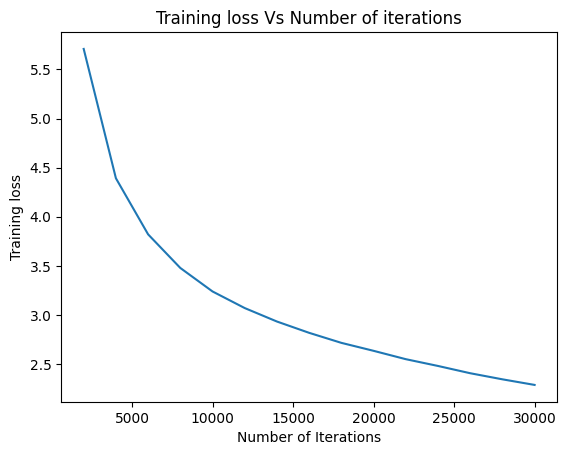

In [38]:
import matplotlib.pyplot as plt
iterations = [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
training_loss = [5.708, 4.392, 3.821, 3.479, 3.240, 3.071, 2.934, 2.819, 2.717 , 2.636, 2.551, 2.482, 2.408, 2.346, 2.289]
plt.plot(iterations, training_loss, label=' Training loss Vs Iterations')
plt.title('Training loss Vs Number of iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Training loss')
plt.show()

In [12]:
print(model)

Transformer(
  (embedding): Embedding(50000, 300)
  (positional_encoding): PositionalEncoding(
    (encoding): Embedding(65, 300)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-2): 3 x DecoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=300, out_features=300, bias=True)
        (W_k): Linear(in_features=300, out_features=300, bias=True)
        (W_v): Linear(in_features=300, out_features=300, bias=True)
        (W_o): Linear(in_features=300, out_features=300, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=300, out_features=300, bias=True)
        (fc2): Linear(in_features=300, out_features=300, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=300, out_feat

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'pretrained.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
torch.save(model.state_dict(), path)

In [41]:
import nltk
nltk.download('movie_reviews')

from nltk.corpus import movie_reviews
from torch.nn import functional as F
import random

documents = [(' '.join(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [42]:
def train_test_split(documents, num_samples):
    i = num_samples // 2
    neg_train = documents[:i]
    pos_train = documents[-i:]
    train = neg_train + pos_train
    test = documents[i:-i]
    random.shuffle(train)
    random.shuffle(test)
    return train, test

sentiment_maxtokens = 64

class TextDataset(torch.utils.data.Dataset):

  def __init__(self, input_data, tokenizer_model):
      self.text = [t for (t, l) in input_data]
      self.label = [1 if l == 'pos' else 0 for (t, l) in input_data]
      self.tokenizer = textF.sentencepiece_tokenizer(tokenizer_model)
      self.numericalizer = textF.sentencepiece_numericalizer(tokenizer_model)
      self.numerictext = list(self.numericalizer(self.text))

  def __len__(self):
      return len(self.label)

  def get_sequence_token(self, idx):
      sequence = self.numerictext[idx]
      len_seq = len(sequence)
      return sequence, len_seq

  def get_labels(self, idx):
      return self.label[idx]

  def __getitem__(self, idx):
      sequence, len_seq = self.get_sequence_token(idx)
      label = self.get_labels(idx)
      return sequence, label, len_seq

def collate_fn(batch):
    bs = len(batch)
    sequences, labels, lengths = zip(*batch)
    trunc_seqs = torch.zeros((bs, sentiment_maxtokens), dtype = torch.long)

    for i in range(len(batch)):
        if len(sequences[i]) < sentiment_maxtokens:
            trunc_seqs[i][:len(sequences[i])] = torch.tensor(sequences[i], dtype = torch.long)
        else:
            trunc_seqs[i] = torch.tensor(torchtext.functional.truncate(sequences[i], sentiment_maxtokens), dtype = torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
    return trunc_seqs, labels

In [43]:
#HYPERPARAMETERS FOR FINETUNING TASK WITHOUT PRETRAINING

src_vocab_size = 50000
tgt_vocab_size = 50000
d_model = 300
num_heads = 2
num_layers = 3
d_ff = 300
max_length = 256
lr = 1e-4
batch_size = 32
finetune_epochs = 20

sizes = [16, 32, 64, 128, 256, 512]

In [44]:
from torch.utils.data import DataLoader
from tqdm import tqdm

#Tranformer architecture for the finetuning task without pretraining

class NoPretrainingTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, num_heads, num_layers, max_length, num_classes = 2, dropout = 0.1, device = 'cuda'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model).to(device)
        self.positional_encoding = PositionalEncoding(d_model, max_len = max_length)
        self.fc = nn.Linear(d_model, num_classes)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.device = device
        self.to(device)

    def forward(self, src):
        embedded = self.embedding(src)
        output = self.positional_encoding(embedded)
        for layer in self.layers:
            output = layer(output, None)
        output = output[:, -1]
        output = self.fc(output)
        return output

def train_classifier(model, dataset, sp_model, epochs, lr, bs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=lr)
    train_dataset = TextDataset(dataset, sp_model)
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, collate_fn=collate_fn, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        total_loss_train = 0
        total_acc_train = 0
        num_pos = 0
        for train_sequence, labels in tqdm(train_dataloader):
            predictions = model(train_sequence.to(device))
            labels = labels.to(device)
            loss = criterion(predictions, labels)

            # Calculate accuracy and loss per batch
            correct = predictions.argmax(axis=1) == labels
            total_acc_train += correct.sum().item()
            total_loss_train += loss.item()

            # Backprop
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

def eval_classifier(model, dataset, sp_model, bs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=lr)
    test_dataset = TextDataset(dataset, sp_model)
    test_dataloader = DataLoader(test_dataset, num_workers=1, batch_size=bs, collate_fn=collate_fn, shuffle=False)

    total_acc_train = 0.
    for sequence, labels in tqdm(test_dataloader):
        predictions = model(sequence.to(device))
        labels = labels.to(device)
        correct = predictions.argmax(axis=1) == labels
        total_acc_train += correct.sum().item()

    return total_acc_train / len(test_dataset)

In [45]:
without_PreTraining_list = []

In [46]:
#Train loop
train_sets = {}
models = {}
for sz in sizes:
    train_sets[sz], test_set = train_test_split(documents, sz)
    models[sz] = NoPretrainingTransformer(src_vocab_size, d_model, d_ff, num_heads, num_layers, max_length)
    print('-' * 56)
    print(f'Training on {sz} samples')
    print('-' * 56)
    train_classifier(models[sz], train_sets[sz], sp_model, finetune_epochs, lr, batch_size)

#Evaluation loop
with torch.no_grad():
    for sz in models:
        print('-' * 56)
        print(f'Evaluating model trained on {sz} samples')
        print('-' * 56)
        test_accuracy = eval_classifier(models[sz], test_set, sp_model, batch_size)
        without_PreTraining_list.append(test_accuracy)
        print("\n Accuracy on test set = %.3f" % test_accuracy)

--------------------------------------------------------
Training on 16 samples
--------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epochs: 1 | Loss:  0.048 | Accuracy:  0.562


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epochs: 2 | Loss:  0.044 | Accuracy:  0.500


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Epochs: 3 | Loss:  0.040 | Accuracy:  0.625


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Epochs: 4 | Loss:  0.045 | Accuracy:  0.500


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epochs: 5 | Loss:  0.039 | Accuracy:  0.688


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epochs: 6 | Loss:  0.034 | Accuracy:  0.812


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Epochs: 7 | Loss:  0.034 | Accuracy:  0.812


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Epochs: 8 | Loss:  0.029 | Accuracy:  0.938


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Epochs: 9 | Loss:  0.026 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Epochs: 10 | Loss:  0.023 | Accuracy:  0.938


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Epochs: 11 | Loss:  0.020 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epochs: 12 | Loss:  0.019 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epochs: 13 | Loss:  0.017 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epochs: 14 | Loss:  0.015 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epochs: 15 | Loss:  0.013 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epochs: 16 | Loss:  0.011 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Epochs: 17 | Loss:  0.009 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epochs: 18 | Loss:  0.008 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epochs: 19 | Loss:  0.006 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epochs: 20 | Loss:  0.005 | Accuracy:  1.000
--------------------------------------------------------
Training on 32 samples
--------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epochs: 1 | Loss:  0.023 | Accuracy:  0.469


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Epochs: 2 | Loss:  0.021 | Accuracy:  0.562


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epochs: 3 | Loss:  0.020 | Accuracy:  0.594


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epochs: 4 | Loss:  0.019 | Accuracy:  0.688


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epochs: 5 | Loss:  0.017 | Accuracy:  0.812


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epochs: 6 | Loss:  0.017 | Accuracy:  0.812


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epochs: 7 | Loss:  0.016 | Accuracy:  0.844


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Epochs: 8 | Loss:  0.015 | Accuracy:  0.844


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epochs: 9 | Loss:  0.014 | Accuracy:  0.906


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epochs: 10 | Loss:  0.014 | Accuracy:  0.875


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epochs: 11 | Loss:  0.012 | Accuracy:  0.938


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epochs: 12 | Loss:  0.010 | Accuracy:  0.969


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epochs: 13 | Loss:  0.010 | Accuracy:  0.938


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epochs: 14 | Loss:  0.010 | Accuracy:  0.969


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epochs: 15 | Loss:  0.008 | Accuracy:  0.969


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epochs: 16 | Loss:  0.007 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epochs: 17 | Loss:  0.007 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epochs: 18 | Loss:  0.006 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epochs: 19 | Loss:  0.005 | Accuracy:  1.000


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epochs: 20 | Loss:  0.004 | Accuracy:  1.000
--------------------------------------------------------
Training on 64 samples
--------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00, 11.88it/s]


Epochs: 1 | Loss:  0.023 | Accuracy:  0.531


100%|██████████| 2/2 [00:00<00:00, 12.29it/s]


Epochs: 2 | Loss:  0.020 | Accuracy:  0.609


100%|██████████| 2/2 [00:00<00:00, 12.24it/s]


Epochs: 3 | Loss:  0.020 | Accuracy:  0.594


100%|██████████| 2/2 [00:00<00:00, 12.28it/s]


Epochs: 4 | Loss:  0.019 | Accuracy:  0.672


100%|██████████| 2/2 [00:00<00:00, 13.18it/s]


Epochs: 5 | Loss:  0.018 | Accuracy:  0.734


100%|██████████| 2/2 [00:00<00:00, 13.07it/s]


Epochs: 6 | Loss:  0.016 | Accuracy:  0.812


100%|██████████| 2/2 [00:00<00:00, 12.65it/s]


Epochs: 7 | Loss:  0.016 | Accuracy:  0.844


100%|██████████| 2/2 [00:00<00:00, 13.18it/s]


Epochs: 8 | Loss:  0.014 | Accuracy:  0.906


100%|██████████| 2/2 [00:00<00:00, 13.17it/s]


Epochs: 9 | Loss:  0.013 | Accuracy:  0.906


100%|██████████| 2/2 [00:00<00:00, 12.55it/s]


Epochs: 10 | Loss:  0.012 | Accuracy:  0.938


100%|██████████| 2/2 [00:00<00:00, 13.42it/s]


Epochs: 11 | Loss:  0.011 | Accuracy:  0.938


100%|██████████| 2/2 [00:00<00:00, 13.37it/s]


Epochs: 12 | Loss:  0.009 | Accuracy:  0.953


100%|██████████| 2/2 [00:00<00:00, 12.70it/s]


Epochs: 13 | Loss:  0.008 | Accuracy:  0.984


100%|██████████| 2/2 [00:00<00:00, 13.29it/s]


Epochs: 14 | Loss:  0.006 | Accuracy:  0.984


100%|██████████| 2/2 [00:00<00:00, 12.43it/s]


Epochs: 15 | Loss:  0.005 | Accuracy:  1.000


100%|██████████| 2/2 [00:00<00:00, 13.02it/s]


Epochs: 16 | Loss:  0.004 | Accuracy:  1.000


100%|██████████| 2/2 [00:00<00:00, 13.13it/s]


Epochs: 17 | Loss:  0.003 | Accuracy:  1.000


100%|██████████| 2/2 [00:00<00:00, 12.93it/s]


Epochs: 18 | Loss:  0.002 | Accuracy:  0.984


100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


Epochs: 19 | Loss:  0.001 | Accuracy:  1.000


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epochs: 20 | Loss:  0.001 | Accuracy:  1.000
--------------------------------------------------------
Training on 128 samples
--------------------------------------------------------


100%|██████████| 4/4 [00:00<00:00, 19.86it/s]


Epochs: 1 | Loss:  0.025 | Accuracy:  0.477


100%|██████████| 4/4 [00:00<00:00, 20.50it/s]


Epochs: 2 | Loss:  0.023 | Accuracy:  0.523


100%|██████████| 4/4 [00:00<00:00, 21.41it/s]


Epochs: 3 | Loss:  0.022 | Accuracy:  0.602


100%|██████████| 4/4 [00:00<00:00, 21.67it/s]


Epochs: 4 | Loss:  0.020 | Accuracy:  0.602


100%|██████████| 4/4 [00:00<00:00, 21.97it/s]


Epochs: 5 | Loss:  0.019 | Accuracy:  0.703


100%|██████████| 4/4 [00:00<00:00, 22.19it/s]


Epochs: 6 | Loss:  0.017 | Accuracy:  0.742


100%|██████████| 4/4 [00:00<00:00, 20.71it/s]


Epochs: 7 | Loss:  0.016 | Accuracy:  0.805


100%|██████████| 4/4 [00:00<00:00, 21.56it/s]


Epochs: 8 | Loss:  0.015 | Accuracy:  0.844


100%|██████████| 4/4 [00:00<00:00, 21.09it/s]


Epochs: 9 | Loss:  0.013 | Accuracy:  0.852


100%|██████████| 4/4 [00:00<00:00, 20.84it/s]


Epochs: 10 | Loss:  0.010 | Accuracy:  0.945


100%|██████████| 4/4 [00:00<00:00, 15.24it/s]


Epochs: 11 | Loss:  0.009 | Accuracy:  0.930


100%|██████████| 4/4 [00:00<00:00, 14.14it/s]


Epochs: 12 | Loss:  0.006 | Accuracy:  0.961


100%|██████████| 4/4 [00:00<00:00, 15.61it/s]


Epochs: 13 | Loss:  0.005 | Accuracy:  0.969


100%|██████████| 4/4 [00:00<00:00, 14.89it/s]


Epochs: 14 | Loss:  0.003 | Accuracy:  0.992


100%|██████████| 4/4 [00:00<00:00, 13.88it/s]


Epochs: 15 | Loss:  0.002 | Accuracy:  0.992


100%|██████████| 4/4 [00:00<00:00, 14.51it/s]


Epochs: 16 | Loss:  0.001 | Accuracy:  1.000


100%|██████████| 4/4 [00:00<00:00, 13.60it/s]


Epochs: 17 | Loss:  0.001 | Accuracy:  0.992


100%|██████████| 4/4 [00:00<00:00, 13.82it/s]


Epochs: 18 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 4/4 [00:00<00:00, 14.98it/s]


Epochs: 19 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 4/4 [00:00<00:00, 14.76it/s]


Epochs: 20 | Loss:  0.004 | Accuracy:  0.945
--------------------------------------------------------
Training on 256 samples
--------------------------------------------------------


100%|██████████| 8/8 [00:00<00:00, 21.75it/s]


Epochs: 1 | Loss:  0.025 | Accuracy:  0.453


100%|██████████| 8/8 [00:00<00:00, 22.19it/s]


Epochs: 2 | Loss:  0.022 | Accuracy:  0.523


100%|██████████| 8/8 [00:00<00:00, 23.00it/s]


Epochs: 3 | Loss:  0.021 | Accuracy:  0.598


100%|██████████| 8/8 [00:00<00:00, 21.26it/s]


Epochs: 4 | Loss:  0.020 | Accuracy:  0.645


100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epochs: 5 | Loss:  0.018 | Accuracy:  0.711


100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


Epochs: 6 | Loss:  0.016 | Accuracy:  0.789


100%|██████████| 8/8 [00:00<00:00, 21.38it/s]


Epochs: 7 | Loss:  0.013 | Accuracy:  0.848


100%|██████████| 8/8 [00:00<00:00, 30.50it/s]


Epochs: 8 | Loss:  0.010 | Accuracy:  0.906


100%|██████████| 8/8 [00:00<00:00, 31.02it/s]


Epochs: 9 | Loss:  0.006 | Accuracy:  0.961


100%|██████████| 8/8 [00:00<00:00, 29.94it/s]


Epochs: 10 | Loss:  0.003 | Accuracy:  0.969


100%|██████████| 8/8 [00:00<00:00, 31.69it/s]


Epochs: 11 | Loss:  0.002 | Accuracy:  0.980


100%|██████████| 8/8 [00:00<00:00, 32.26it/s]


Epochs: 12 | Loss:  0.001 | Accuracy:  0.992


100%|██████████| 8/8 [00:00<00:00, 32.43it/s]


Epochs: 13 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 8/8 [00:00<00:00, 30.32it/s]


Epochs: 14 | Loss:  0.001 | Accuracy:  0.996


100%|██████████| 8/8 [00:00<00:00, 27.81it/s]


Epochs: 15 | Loss:  0.005 | Accuracy:  0.949


100%|██████████| 8/8 [00:00<00:00, 30.02it/s]


Epochs: 16 | Loss:  0.001 | Accuracy:  0.988


100%|██████████| 8/8 [00:00<00:00, 30.75it/s]


Epochs: 17 | Loss:  0.000 | Accuracy:  0.996


100%|██████████| 8/8 [00:00<00:00, 30.08it/s]


Epochs: 18 | Loss:  0.002 | Accuracy:  0.980


100%|██████████| 8/8 [00:00<00:00, 31.59it/s]


Epochs: 19 | Loss:  0.003 | Accuracy:  0.977


100%|██████████| 8/8 [00:00<00:00, 31.38it/s]


Epochs: 20 | Loss:  0.001 | Accuracy:  0.992
--------------------------------------------------------
Training on 512 samples
--------------------------------------------------------


100%|██████████| 16/16 [00:00<00:00, 33.89it/s]


Epochs: 1 | Loss:  0.024 | Accuracy:  0.465


100%|██████████| 16/16 [00:00<00:00, 38.83it/s]


Epochs: 2 | Loss:  0.022 | Accuracy:  0.549


100%|██████████| 16/16 [00:00<00:00, 39.28it/s]


Epochs: 3 | Loss:  0.020 | Accuracy:  0.627


100%|██████████| 16/16 [00:00<00:00, 40.14it/s]


Epochs: 4 | Loss:  0.018 | Accuracy:  0.695


100%|██████████| 16/16 [00:00<00:00, 40.90it/s]


Epochs: 5 | Loss:  0.016 | Accuracy:  0.770


100%|██████████| 16/16 [00:00<00:00, 40.20it/s]


Epochs: 6 | Loss:  0.013 | Accuracy:  0.828


100%|██████████| 16/16 [00:00<00:00, 40.25it/s]


Epochs: 7 | Loss:  0.010 | Accuracy:  0.865


100%|██████████| 16/16 [00:00<00:00, 40.88it/s]


Epochs: 8 | Loss:  0.007 | Accuracy:  0.918


100%|██████████| 16/16 [00:00<00:00, 41.22it/s]


Epochs: 9 | Loss:  0.004 | Accuracy:  0.949


100%|██████████| 16/16 [00:00<00:00, 33.52it/s]


Epochs: 10 | Loss:  0.002 | Accuracy:  0.982


100%|██████████| 16/16 [00:00<00:00, 28.60it/s]


Epochs: 11 | Loss:  0.002 | Accuracy:  0.979


100%|██████████| 16/16 [00:00<00:00, 26.52it/s]


Epochs: 12 | Loss:  0.002 | Accuracy:  0.979


100%|██████████| 16/16 [00:00<00:00, 28.35it/s]


Epochs: 13 | Loss:  0.003 | Accuracy:  0.973


100%|██████████| 16/16 [00:00<00:00, 27.58it/s]


Epochs: 14 | Loss:  0.001 | Accuracy:  0.994


100%|██████████| 16/16 [00:00<00:00, 28.38it/s]


Epochs: 15 | Loss:  0.001 | Accuracy:  0.977


100%|██████████| 16/16 [00:00<00:00, 32.31it/s]


Epochs: 16 | Loss:  0.002 | Accuracy:  0.977


100%|██████████| 16/16 [00:00<00:00, 27.38it/s]


Epochs: 17 | Loss:  0.004 | Accuracy:  0.965


100%|██████████| 16/16 [00:00<00:00, 28.51it/s]


Epochs: 18 | Loss:  0.004 | Accuracy:  0.961


100%|██████████| 16/16 [00:00<00:00, 31.60it/s]


Epochs: 19 | Loss:  0.003 | Accuracy:  0.973


100%|██████████| 16/16 [00:00<00:00, 31.89it/s]


Epochs: 20 | Loss:  0.003 | Accuracy:  0.967
--------------------------------------------------------
Evaluating model trained on 16 samples
--------------------------------------------------------


100%|██████████| 47/47 [00:00<00:00, 91.59it/s] 



 Accuracy on test set = 0.479
--------------------------------------------------------
Evaluating model trained on 32 samples
--------------------------------------------------------


100%|██████████| 47/47 [00:00<00:00, 94.19it/s] 



 Accuracy on test set = 0.494
--------------------------------------------------------
Evaluating model trained on 64 samples
--------------------------------------------------------


100%|██████████| 47/47 [00:00<00:00, 56.68it/s]



 Accuracy on test set = 0.517
--------------------------------------------------------
Evaluating model trained on 128 samples
--------------------------------------------------------


100%|██████████| 47/47 [00:00<00:00, 93.59it/s] 



 Accuracy on test set = 0.491
--------------------------------------------------------
Evaluating model trained on 256 samples
--------------------------------------------------------


100%|██████████| 47/47 [00:00<00:00, 89.38it/s] 



 Accuracy on test set = 0.511
--------------------------------------------------------
Evaluating model trained on 512 samples
--------------------------------------------------------


100%|██████████| 47/47 [00:00<00:00, 52.90it/s]


 Accuracy on test set = 0.511


In [47]:
def train_classifier(model, dataset, sp_model, epochs, lr, bs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=lr)
    train_dataset = TextDataset(dataset, sp_model)
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, collate_fn=collate_fn, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        total_loss_train = 0
        total_acc_train = 0
        num_pos = 0
        for train_sequence, labels in tqdm(train_dataloader):
            predictions = model(train_sequence.to(device))
            preds = predictions[:, -1]
            labels = labels.to(device)
            loss = criterion(preds, labels)

            # Calculate accuracy and loss per batch
            correct = preds.argmax(axis=1) == labels
            total_acc_train += correct.sum().item()
            total_loss_train += loss.item()

            # Backprop
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

In [48]:
with_PreTraining_list = []

In [ ]:
lr = 1e-4
batch_size = 64
finetune_epochs = 20

#Train loop
train_sets = {}
finetuned_models = {}
for sz in sizes:
    train_sets[sz], test_set = train_test_split(documents, sz)
    pretrained = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
    pretrained.load_state_dict(torch.load('/content/pretrained.pt'))
    finetuned_models[sz] = pretrained
    finetuned_models[sz].fc = nn.Linear(d_model, 2).to(device)
    print('-' * 56)
    print(f'Training on {2 * sz} samples')
    print('-' * 56)
    train_classifier(finetuned_models[sz], train_sets[sz], sp_model, finetune_epochs, lr, batch_size)

In [50]:
def eval_classifier(model, dataset, sp_model, bs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=lr)
    test_dataset = TextDataset(dataset, sp_model)
    test_dataloader = DataLoader(test_dataset, num_workers=1, batch_size=bs, collate_fn=collate_fn, shuffle=False)

    total_acc = 0.
    for sequence, labels in tqdm(test_dataloader):
        predictions = model(sequence.to(device))
        preds = predictions[:, -1]
        labels = labels.to(device)
        correct = preds.argmax(axis=1) == labels
        total_acc += correct.sum().item()

    return total_acc / len(test_dataset)

In [ ]:
#Evaluation loop
with torch.no_grad():
    for sz in finetuned_models:
        print('-' * 56)
        print(f'Evaluating model trained on {sz} samples')
        print('-' * 56)
        test_accuracy = eval_classifier(finetuned_models[sz], test_set, sp_model, batch_size)
        with_PreTraining_list.append(test_accuracy)
        print("\n Accuracy on test set = %.3f" % test_accuracy)

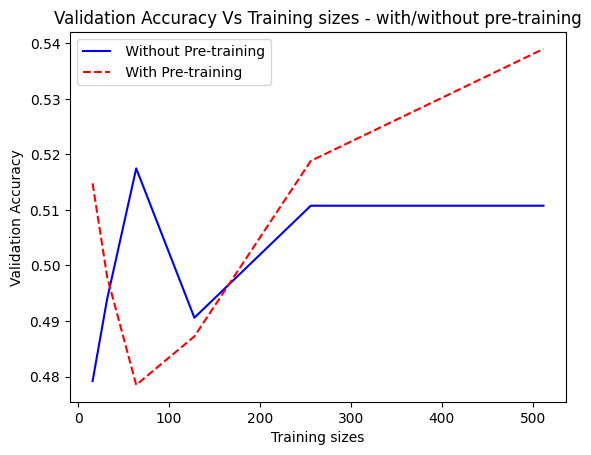

In [52]:
import matplotlib.pyplot as plt
plt.plot(sizes, without_PreTraining_list, label=' Without Pre-training', color='blue', linestyle='-')
plt.plot(sizes, with_PreTraining_list, label=' With Pre-training', color='red', linestyle='--')
plt.title('Validation Accuracy Vs Training sizes - with/without pre-training')
plt.xlabel('Training sizes')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
